# Multi-Kernel CNN을 이용한 영어 문장 의도 분류

## 데이터 로드하기

In [100]:
import pandas as pd
import numpy as np
import tensorflow as tf
import urllib.request
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import string
from hanspell import spell_checker
from tqdm.notebook import tqdm
from soynlp.normalizer import *
import MeCab
from konlpy.tag import *
import json
import re
from sklearn.model_selection import train_test_split
import random
import nltk
import wget

class Mecab:
    def pos(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def morphs(self, text):
        p = re.compile(".+\t[A-Z]+")
        return [p.match(line).group().split("\t")[0] for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
    
    def nouns(self, text):
        p = re.compile(".+\t[A-Z]+")
        temp = [tuple(p.match(line).group().split("\t")) for line in MeCab.Tagger().parse(text).splitlines()[:-1]]
        nouns=[]
        for word in temp:
            if word[1] in ["NNG", "NNP", "NNB", "NNBC", "NP", "NR"]:
                nouns.append(word[0])
        return nouns
    
mcb = Mecab()

tqdm.pandas()

plt.style.use("dark_background")

C:\Users\5CG7092POZ\Anaconda3\envs\tf2.3\lib\site-packages\tqdm\std.py:703: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
embedding_dim = 100 
n_of_val = 0.10

In [2]:
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_text.npy", filename="train_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_text.npy", filename="test_text.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/train_label.npy", filename="train_label.npy")
urllib.request.urlretrieve("https://github.com/ajinkyaT/CNN_Intent_Classification/raw/master/data/test_label.npy", filename="test_label.npy")

('test_label.npy', <http.client.HTTPMessage at 0x1f594c3d588>)

In [83]:
intent_train = np.load("train_text.npy").tolist()
label_train = np.load("train_label.npy").tolist()

intent_test = np.load("test_text.npy").tolist()
label_test = np.load("test_label.npy").tolist()

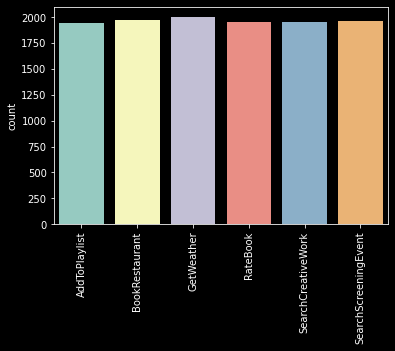

In [26]:
fig, ax = plt.subplots()

sb.countplot(ax=ax, x=label_train)

ax.tick_params(axis="x", labelrotation=90)

In [84]:
le = sklearn.preprocessing.LabelEncoder()
le.fit(label_train)
label_train = le.transform(label_train)
label_test = le.transform(label_test)
label2idx = dict(zip(le.classes_, set(label_train)))

## 토큰화 & 정수 인코딩 & 패딩

In [85]:
random.sample(intent_train, 5)

['what cinema is the railway children',
 'book a restaurant with a pool with alta , deborah and bertha in ia',
 'is it warm in fernley \\?',
 'will it be rainy faraway in charleston lake provincial park in 13 hours \\?',
 'what are the movie times for movies close by']

In [86]:
tkn = tf.keras.preprocessing.text.Tokenizer()
tkn.fit_on_texts(intent_train)

word2idx = tkn.word_index
word2cnts = dict(sorted(tkn.word_counts.items(), key=lambda x:x[1], reverse=True))

cnts = list(word2cnts.values())
ratio = 0.99
for vocab_size, value in enumerate(np.cumsum(cnts)/np.sum(cnts)):
    if value >= ratio:
        break

print(f"{vocab_size:,}개의 단어로 전체 data의 {ratio:.0%}를 표현할 수 있습니다.")
print(f"{len(word2idx):,}개의 단어 중 {vocab_size/len(word2idx):.1%}에 해당합니다.")

8,765개의 단어로 전체 data의 99%를 표현할 수 있습니다.
9,869개의 단어 중 88.8%에 해당합니다.


In [87]:
tkn = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size+2, oov_token="UNK")
tkn.fit_on_texts(intent_train)

X_train = tkn.texts_to_sequences(intent_train)
X_test = tkn.texts_to_sequences(intent_test)

lens = sorted([len(doc) for doc in X_train])
for idx, max_len in enumerate(lens):
    if idx/len(lens) >= ratio:
        break
print(f"길이가 {max_len} 이하인 리뷰가 전체의 {ratio:.0%}를 차지합니다.")

길이가 19 이하인 리뷰가 전체의 99%를 차지합니다.


In [95]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_len)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_len)

In [96]:
X_train = 

array([[   0,    0,    0, ..., 1142, 1573,   16],
       [   0,    0,    0, ...,  257,  189,  549],
       [   0,    0,    0, ..., 4015,    5, 1969],
       ...,
       [   0,    0,    0, ...,    1,  930,  104],
       [   0,    0,    0, ...,   54,   19,   78],
       [   0,    0,    0, ...,    2,  106,   42]])

In [ ]:
# # split the data into a training set and a validation set
# indices = np.arange(intent_train.shape[0])
# np.random.shuffle(indices)

# print(indices)

# intent_train = intent_train[indices]
# label_train = label_train[indices]

## 검증 데이터 분리

In [ ]:
n_of_val = int(0.1 * intent_train.shape[0])

In [ ]:
print(n_of_val)

1178


In [ ]:
X_train = intent_train[:-n_of_val]
y_train = label_train[:-n_of_val]
X_val = intent_train[-n_of_val:]
y_val = label_train[-n_of_val:]
X_test = intent_test
y_test = label_test

In [ ]:
print('훈련 데이터의 크기(shape):', X_train.shape)
print('검증 데이터의 크기(shape):', X_val.shape)
print('훈련 데이터 레이블의 개수(shape):', y_train.shape)
print('검증 데이터 레이블의 개수(shape):', y_val.shape)
print('테스트 데이터의 개수 :', len(X_test))
print('테스트 데이터 레이블의 개수 :', len(y_test))

훈련 데이터의 크기(shape): (10606, 35)
검증 데이터의 크기(shape): (1178, 35)
훈련 데이터 레이블의 개수(shape): (10606, 6)
검증 데이터 레이블의 개수(shape): (1178, 6)
테스트 데이터의 개수 : 600
테스트 데이터 레이블의 개수 : 600


## 사전 훈련된 워드 임베딩(Pre-traiend Word Embedding)

In [101]:
import zipfile

In [ ]:
wget.download("http://nlp.stanford.edu/data/glove.6B.zip")

 18% [............                                                          ] 157220864 / 862182613

In [99]:
!unzip glove*.zip

with zipfile.ZipFile("glove.6B.zip", "r") as z:

SyntaxError: invalid syntax (<ipython-input-99-f70dc9fd845d>, line 1)

In [ ]:
print('Indexing word vectors.')

embedding_dict = dict()
f = open(os.path.join('glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()

print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

Indexing word vectors.
400000개의 Embedding vector가 있습니다.


In [ ]:
print(embedding_dict['respectable'])
print(len(embedding_dict['respectable']))

[-0.049773   0.19903    0.10585    0.1391    -0.32395    0.44053
  0.3947    -0.22805   -0.25793    0.49768    0.15384   -0.08831
  0.0782    -0.8299    -0.037788   0.16772   -0.45197   -0.17085
  0.74756    0.98256    0.81872    0.28507    0.16178   -0.48626
 -0.006265  -0.92469   -0.30625   -0.067318  -0.046762  -0.76291
 -0.0025264 -0.018795   0.12882   -0.52457    0.3586     0.43119
 -0.89477   -0.057421  -0.53724    0.25587    0.55195    0.44698
 -0.24252    0.29946    0.25776   -0.8717     0.68426   -0.05688
 -0.1848    -0.59352   -0.11227   -0.57692   -0.013593   0.18488
 -0.32507   -0.90171    0.17672    0.075601   0.54896   -0.21488
 -0.54018   -0.45882   -0.79536    0.26331    0.18879   -0.16363
  0.3975     0.1099     0.1164    -0.083499   0.50159    0.35802
  0.25677    0.088546   0.42108    0.28674   -0.71285   -0.82915
  0.15297   -0.82712    0.022112   1.067     -0.31776    0.1211
 -0.069755  -0.61327    0.27308   -0.42638   -0.085084  -0.17694
 -0.0090944  0.1109     0.

In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
np.shape(embedding_matrix)

(9870, 100)

## 멀티 커널 합성곱 신경망

We will now try to build model described in "Convolutional Neural Networks for Sentence Classification
", https://arxiv.org/abs/1408.5882

It is highly recommended to read, "A Sensitivity Analysis of (and Practitioners' Guide to) Convolutional Neural Networks for Sentence Classification", https://arxiv.org/abs/1510.03820 to get an intuition behind the various hyperparameters chosen to build our model.

In [ ]:
filter_sizes = [2,3,5]
num_filters = 512
drop = 0.5

In [ ]:
model_input = Input(shape = (max_len,))
z = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix],
                      input_length=max_len, trainable=False)(model_input)

conv_blocks = []

for sz in filter_sizes:
    conv = Conv1D(filters = num_filters,
                         kernel_size = sz,
                         padding = "valid",
                         activation = "relu",
                         strides = 1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

In [ ]:
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]
z = Dropout(drop)(z)
model_output = Dense(len(label_idx), activation='softmax')(z)

In [ ]:
model = Model(model_input, model_output)

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 100)      987000      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 34, 512)      102912      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 33, 512)      154112      embedding[0][0]                  
______________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=10,
          validation_data = (X_val, y_val))

Epoch 1/10
166/166 [==============================] - 2s 9ms/step - loss: 0.2117 - acc: 0.9334 - val_loss: 0.0677 - val_acc: 0.9788
Epoch 2/10
166/166 [==============================] - 1s 6ms/step - loss: 0.0477 - acc: 0.9875 - val_loss: 0.0396 - val_acc: 0.9898
Epoch 3/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0315 - acc: 0.9915 - val_loss: 0.0405 - val_acc: 0.9898
Epoch 4/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0183 - acc: 0.9953 - val_loss: 0.0371 - val_acc: 0.9864
Epoch 5/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0118 - acc: 0.9961 - val_loss: 0.0429 - val_acc: 0.9864
Epoch 6/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0088 - acc: 0.9975 - val_loss: 0.0359 - val_acc: 0.9898
Epoch 7/10
166/166 [==============================] - 1s 7ms/step - loss: 0.0103 - acc: 0.9969 - val_loss: 0.0401 - val_acc: 0.9873
Epoch 8/10
166/166 [==============================] - 1s 6ms/step - loss: 0.

훈련 데이터와 검증 데이터에서 각각 99%와 98%의 정확도를 얻어냅니다.  
사전 훈련된 워드 임베딩의 힘이 크지 않았나 생각합니다.  
일반 Embedding()으로도 한 번 해보세요

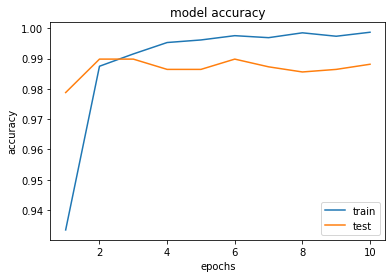

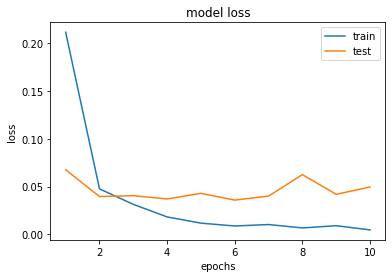

In [ ]:
# summarize history for accuracy
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# summarize history for loss
epochs = range(1, len(history.history['loss']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## 테스트 데이터에 대한 평가

현재 검증 데이터와 테스트 데이터를 다른 데이터를 사용하고 있으므로 테스트 데이터에 대해서도 평가해봅시다.

In [ ]:
# Get predictions
# Processing text to be compatible with model input
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.argmax(axis=-1) # 예측된 정수 시퀀스로 변환

In [ ]:
y_predicted = idx_encode.inverse_transform(y_predicted) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환
y_test = idx_encode.inverse_transform(y_test) # 정수 시퀀스를 레이블에 해당하는 텍스트 시퀀스로 변환

In [ ]:
print('accuracy: ', sum(y_predicted == y_test) / len(y_test))
print("Precision, Recall and F1-Score:\n\n", classification_report(y_test, y_predicted))

accuracy:  0.99
Precision, Recall and F1-Score:

                       precision    recall  f1-score   support

       AddToPlaylist       1.00      1.00      1.00       100
      BookRestaurant       1.00      1.00      1.00       100
          GetWeather       0.99      0.99      0.99       100
            RateBook       1.00      1.00      1.00       100
  SearchCreativeWork       0.96      1.00      0.98       100
SearchScreeningEvent       0.99      0.95      0.97       100

            accuracy                           0.99       600
           macro avg       0.99      0.99      0.99       600
        weighted avg       0.99      0.99      0.99       600



합성곱 신경망을 통해 테스트 데이터에서 99%의 정확도를 얻어냅니다.

# LSTM을 이용한 한국어 문장 의도 분류

## 간단한 설정과 데이터 로드

In [ ]:
!pip install konlpy

In [ ]:
# colab에서 그래프를 그릴 때 한글이 깨지지 않도록 해주는 코드
# 코드 실행 > Colab 상단의 런타임 > 런타임 다시 시작 > 코드 재실행
# 이후에는 matplotlib으로 그리는 그래프에서 한글이 깨지지 않습니다.
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'

!apt -qq -y install fonts-nanum

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [ ]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/hukim1112/comment_classifier/master/train_intent.csv", filename="train_intent.csv")

('train_intent.csv', <http.client.HTTPMessage at 0x7fe168d9f748>)

In [ ]:
df = pd.read_csv('train_intent.csv')
df.sample(20)

,question,intent
1966,김희철 누구지요,인물
2691,지금 이슈 알려줘,이슈
1249,오늘 무슨 날인지 알려줄래,달력
1893,박도현 누구냐,인물
1550,먼지도 알려줄래,먼지
1168,멋진 명언 들려줘요,명언
847,저번 주 야구 결과 알려줄래요,뉴스
2087,이율곡 누구에요,인물
985,나에게 명언 들려줄래요,명언
1974,이정휴 누군지 궁금해요,인물


In [ ]:
print('샘플 수 :', len(df))

샘플 수 : 3591


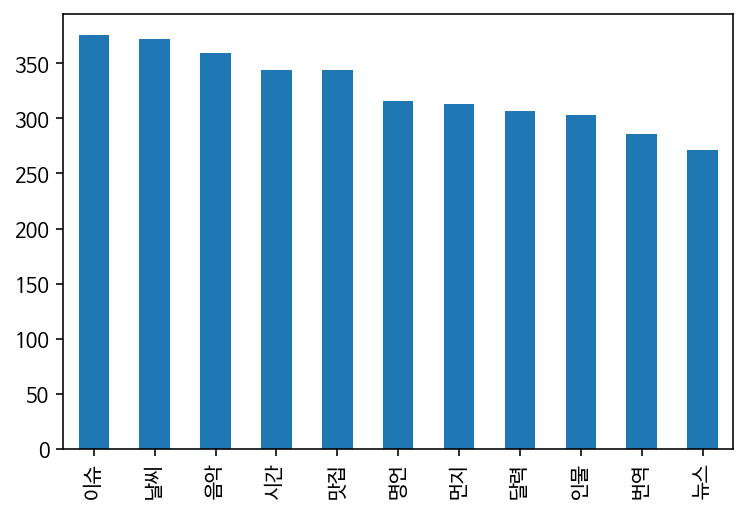

In [ ]:
df['intent'].value_counts().plot(kind = 'bar')

In [ ]:
print(df.groupby('intent').size().reset_index(name = 'count'))

   intent  count
0      날씨    372
1      뉴스    271
2      달력    307
3      맛집    344
4      먼지    313
5      명언    316
6      번역    286
7      시간    344
8      음악    359
9      이슈    376
10     인물    303


In [ ]:
print(df.isnull().values.any())

False


## 토큰화

In [ ]:
okt = Okt()
okt.morphs('주변에 이런 음식 추천해줘요')

['주변', '에', '이런', '음식', '추천', '해줘요']

In [ ]:
X_train = []
for sentence in df.question:
    temp_X = []
    temp_X = okt.morphs(sentence)
    X_train.append(temp_X)

In [ ]:
print(X_train[:3])

[['에픽하이', '우산', '들려줘'], ['윤하', '우산', '들려줘'], ['윤하', '의', '우산', '들려주라']]


## 단어 집합(Vocabulary) 생성과 정수 인코딩

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)

In [ ]:
print(X_train[:3])

[[182, 70, 17], [189, 70, 17], [189, 36, 70, 97]]


In [ ]:
print(tokenizer.word_index)

{'오늘': 1, '알려줘': 2, '명언': 3, '이': 4, '누구': 5, '알려줘요': 6, '몇': 7, '날씨': 8, '지금': 9, '주': 10, '해줘': 11, '시간': 12, '뭐': 13, '노래': 14, '추천': 15, '상태': 16, '들려줘': 17, '말': 18, '공기': 19, '이슈': 20, '요': 21, '무슨': 22, '좀': 23, '이번': 24, '맛집': 25, '요즘': 26, '나': 27, '알려줄래': 28, '주변': 29, '내일': 30, '해줘요': 31, '알려주라': 32, '지': 33, '며칠': 34, '알려줄래요': 35, '의': 36, '좋은': 37, '뉴스': 38, '사건': 39, '현재': 40, '이제': 41, '곧': 42, '번역': 43, '날짜': 44, '에요': 45, '에게': 46, '되는': 47, '인가요': 48, '뭔': 49, '거': 50, '핫': 51, '미세먼지': 52, '하나': 53, '시야': 54, '니': 55, '가장': 56, '화제': 57, '어디': 58, '중국어': 59, '있나요': 60, '이야': 61, '요일': 62, '인지': 63, '힘': 64, '들려줘요': 65, '일': 66, '에': 67, '마스크': 68, '어떻게': 69, '우산': 70, '해주라': 71, '가': 72, '해주세요': 73, '멋진': 74, '결과': 75, '바람': 76, '프랑스어': 77, '다음': 78, '있니': 79, '전': 80, '누군지': 81, '알려주세요': 82, '라': 83, '영어': 84, '음악': 85, '최근': 86, '시': 87, '치킨': 88, '분': 89, '수': 90, '해줄래': 91, '해줄래요': 92, '만': 93, '어때': 94, '비': 95, '음식': 96, '들려주라': 97, '야': 98, '아니': 99, '음식점': 100

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합(Vocabulary)의 크기 :', vocab_size)

단어 집합(Vocabulary)의 크기 : 1402


##패딩(Padding)

문장의 최대 길이 : 10
문장의 평균 길이 : 4.111389585073796


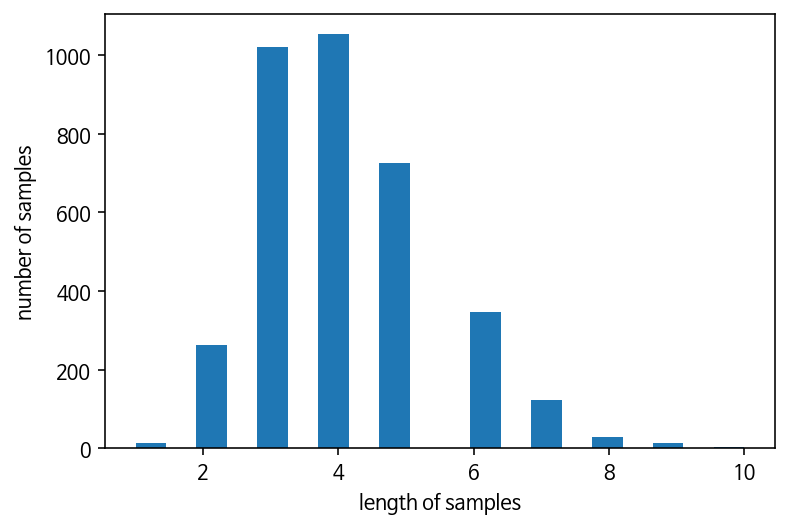

In [ ]:
print('문장의 최대 길이 :',max(len(l) for l in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=20)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
max_len = 10
X_train = pad_sequences(X_train, maxlen = max_len, padding='post')

In [ ]:
print(X_train[:3])

[[182  70  17   0   0   0   0   0   0   0]
 [189  70  17   0   0   0   0   0   0   0]
 [189  36  70  97   0   0   0   0   0   0]]


## 레이블 정수 인코딩 (텍스트를 고유한 정수로 변환)

In [ ]:
# 레이블 인코딩. 레이블을 정수로 변환
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(df['intent'])

y_train = idx_encode.transform(df['intent'])

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print(label_idx)

{'날씨': 0, '뉴스': 1, '달력': 2, '맛집': 3, '먼지': 4, '명언': 5, '번역': 6, '시간': 7, '음악': 8, '이슈': 9, '인물': 10}


In [ ]:
idx_label = {}
for key, value in label_idx.items():
    idx_label[value] = key

In [ ]:
y_train[:3]

array([8, 8, 8])

## LSTM을 이용한 의도 분류

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 64))
model.add(LSTM(256))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_idx), activation='softmax'))

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs = 15, batch_size = 64)

Epoch 1/15
57/57 [==============================] - 0s 4ms/step - loss: 1.6348 - acc: 0.3829
Epoch 2/15
57/57 [==============================] - 0s 4ms/step - loss: 0.4237 - acc: 0.8716
Epoch 3/15
57/57 [==============================] - 0s 4ms/step - loss: 0.1349 - acc: 0.9627
Epoch 4/15
57/57 [==============================] - 0s 8ms/step - loss: 0.1289 - acc: 0.9674
Epoch 5/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0631 - acc: 0.9858
Epoch 6/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0698 - acc: 0.9850
Epoch 7/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0207 - acc: 0.9936
Epoch 8/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0785 - acc: 0.9813
Epoch 9/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0452 - acc: 0.9894
Epoch 10/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0135 - acc: 0.9964
Epoch 11/15
57/57 [==============================] - 0s 4ms/step - lo

## 테스트 데이터에 대한 평가

In [ ]:
def question_processing(sentences):
    inputs = []
    for sentence in sentences:
        sentence = okt.morphs(sentence) 
        encoded = tokenizer.texts_to_sequences([sentence])
        inputs.append(encoded[0])
    padded_inputs = pad_sequences(inputs, maxlen=max_len, padding='post')
    return padded_inputs

In [ ]:
input_sentence = question_processing(['서울 날씨 어때?', 
                                      '나는 전주 날씨 궁금함',
                                      '안중근 의사는 누구야?',
                                      '이순신 장군님은 어떤 사람이니?',
                                      '명동 맛있는 음식점 있니?'
                                     ])

In [ ]:
print(input_sentence)

[[ 149    8   94    0    0    0    0    0    0    0]
 [  27  127  132    8    0    0    0    0    0    0]
 [1257  127    5   98    0    0    0    0    0    0]
 [1211  229  117  324  222    0    0    0    0    0]
 [ 107  100   79    0    0    0    0    0    0    0]]


In [ ]:
prediction = np.argmax(model.predict(input_sentence), axis=1)
print(prediction)

[ 0  0 10  1  3]


In [ ]:
for p in prediction:
    print(idx_label[p])

날씨
날씨
인물
뉴스
맛집


## 잘못된 분류 결과를 새로운 데이터를 추가하여 보정하기

In [ ]:
names = ['안중근', '이순신', '세종대왕', '김광석', '아이유', '에미넴', '이건희', '고아라', '유재석', '한석희', '최민성']
def question_generator(names):
    question = []
    for name in names:
        s1 = name+'는 어떤 분이야?'
        s2 = name+'은 어떤 사람이니?'
        s3 = name+'이란 사람에 대해 궁금해'
        question = question+[s1, s2, s3]
    return question
question = question_generator(names)

In [ ]:
question

['안중근는 어떤 분이야?',
 '안중근은 어떤 사람이니?',
 '안중근이란 사람에 대해 궁금해',
 '이순신는 어떤 분이야?',
 '이순신은 어떤 사람이니?',
 '이순신이란 사람에 대해 궁금해',
 '세종대왕는 어떤 분이야?',
 '세종대왕은 어떤 사람이니?',
 '세종대왕이란 사람에 대해 궁금해',
 '김광석는 어떤 분이야?',
 '김광석은 어떤 사람이니?',
 '김광석이란 사람에 대해 궁금해',
 '아이유는 어떤 분이야?',
 '아이유은 어떤 사람이니?',
 '아이유이란 사람에 대해 궁금해',
 '에미넴는 어떤 분이야?',
 '에미넴은 어떤 사람이니?',
 '에미넴이란 사람에 대해 궁금해',
 '이건희는 어떤 분이야?',
 '이건희은 어떤 사람이니?',
 '이건희이란 사람에 대해 궁금해',
 '고아라는 어떤 분이야?',
 '고아라은 어떤 사람이니?',
 '고아라이란 사람에 대해 궁금해',
 '유재석는 어떤 분이야?',
 '유재석은 어떤 사람이니?',
 '유재석이란 사람에 대해 궁금해',
 '한석희는 어떤 분이야?',
 '한석희은 어떤 사람이니?',
 '한석희이란 사람에 대해 궁금해',
 '최민성는 어떤 분이야?',
 '최민성은 어떤 사람이니?',
 '최민성이란 사람에 대해 궁금해']

In [ ]:
new_data = {'question' : question, 'intent' : ['인물']*len(question)}
add_df = pd.DataFrame(new_data, columns=('question', 'intent'))

In [ ]:
add_df.head(5)

,question,intent
0,안중근는 어떤 분이야?,인물
1,안중근은 어떤 사람이니?,인물
2,안중근이란 사람에 대해 궁금해,인물
3,이순신는 어떤 분이야?,인물
4,이순신은 어떤 사람이니?,인물


In [ ]:
print(len(df), len(add_df))

3591 33


In [ ]:
new_df = pd.concat([df, add_df])
print(len(new_df))

3624


In [ ]:
new_df

,question,intent
0,에픽하이 우산 들려줘,음악
1,윤하 우산 들려줘,음악
2,윤하의 우산 들려주라,음악
3,우산 노래 들려줘,음악
4,에픽하이의 우산 들려줘,음악
...,...,...
28,한석희은 어떤 사람이니?,인물
29,한석희이란 사람에 대해 궁금해,인물
30,최민성는 어떤 분이야?,인물
31,최민성은 어떤 사람이니?,인물


In [ ]:
X_train = []
for sentence in new_df.question:
    temp_X = []
    temp_X = okt.morphs(sentence)
    X_train.append(temp_X)

In [ ]:
print(X_train[:3])

[['에픽하이', '우산', '들려줘'], ['윤하', '우산', '들려줘'], ['윤하', '의', '우산', '들려주라']]


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train)

In [ ]:
print(X_train[:3])

[[186, 72, 17], [193, 72, 17], [193, 36, 72, 99]]


In [ ]:
print(tokenizer.word_index)

{'오늘': 1, '알려줘': 2, '명언': 3, '이': 4, '누구': 5, '알려줘요': 6, '몇': 7, '날씨': 8, '지금': 9, '주': 10, '해줘': 11, '시간': 12, '뭐': 13, '노래': 14, '추천': 15, '상태': 16, '들려줘': 17, '말': 18, '공기': 19, '이슈': 20, '요': 21, '무슨': 22, '좀': 23, '이번': 24, '맛집': 25, '요즘': 26, '나': 27, '알려줄래': 28, '주변': 29, '내일': 30, '해줘요': 31, '알려주라': 32, '지': 33, '며칠': 34, '알려줄래요': 35, '의': 36, '좋은': 37, '뉴스': 38, '사건': 39, '현재': 40, '이제': 41, '곧': 42, '번역': 43, '날짜': 44, '에요': 45, '에게': 46, '되는': 47, '인가요': 48, '뭔': 49, '이야': 50, '거': 51, '핫': 52, '미세먼지': 53, '하나': 54, '시야': 55, '니': 56, '에': 57, '가장': 58, '화제': 59, '어디': 60, '중국어': 61, '있나요': 62, '요일': 63, '인지': 64, '힘': 65, '들려줘요': 66, '일': 67, '분': 68, '마스크': 69, '어떻게': 70, '어떤': 71, '우산': 72, '해주라': 73, '가': 74, '해주세요': 75, '멋진': 76, '결과': 77, '바람': 78, '프랑스어': 79, '다음': 80, '있니': 81, '전': 82, '누군지': 83, '알려주세요': 84, '라': 85, '영어': 86, '궁금해': 87, '음악': 88, '최근': 89, '시': 90, '치킨': 91, '수': 92, '해줄래': 93, '해줄래요': 94, '만': 95, '어때': 96, '비': 97, '음식': 98, '들려주라': 99, '야': 100

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print('단어 집합(Vocabulary)의 크기 :', vocab_size)

단어 집합(Vocabulary)의 크기 : 1410


In [ ]:
max_len = 10
X_train = pad_sequences(X_train, maxlen = max_len, padding='post')

In [ ]:
# 레이블 인코딩. 레이블을 정수로 변환
idx_encode = preprocessing.LabelEncoder()
idx_encode.fit(new_df['intent'])

y_train = idx_encode.transform(new_df['intent'])

label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
print(label_idx)

{'날씨': 0, '뉴스': 1, '달력': 2, '맛집': 3, '먼지': 4, '명언': 5, '번역': 6, '시간': 7, '음악': 8, '이슈': 9, '인물': 10}


In [ ]:
idx_label = {}
for key, value in label_idx.items():
    idx_label[value] = key

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 64))
model.add(LSTM(256))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(label_idx), activation='softmax'))

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit(X_train, y_train, epochs = 15, batch_size = 64)

Epoch 1/15
57/57 [==============================] - 0s 4ms/step - loss: 1.5398 - acc: 0.3962
Epoch 2/15
57/57 [==============================] - 0s 4ms/step - loss: 0.4812 - acc: 0.8267
Epoch 3/15
57/57 [==============================] - 0s 4ms/step - loss: 0.2358 - acc: 0.9302
Epoch 4/15
57/57 [==============================] - 0s 4ms/step - loss: 0.1471 - acc: 0.9578
Epoch 5/15
57/57 [==============================] - 0s 4ms/step - loss: 0.1222 - acc: 0.9641
Epoch 6/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0970 - acc: 0.9782
Epoch 7/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0620 - acc: 0.9823
Epoch 8/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0637 - acc: 0.9840
Epoch 9/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0314 - acc: 0.9903
Epoch 10/15
57/57 [==============================] - 0s 4ms/step - loss: 0.0683 - acc: 0.9862
Epoch 11/15
57/57 [==============================] - 0s 4ms/step - lo

In [ ]:
input_sentence = question_processing(['서울 날씨 어때?', 
                                      '나는 전주 날씨 궁금함',
                                      '안중근 의사는 누구야?',
                                      '이순신 장군님은 어떤 사람이니?',
                                      '명동 맛있는 음식점 있니?'
                                     ])

In [ ]:
input_sentence

array([[152,   8,  96, 143,   0,   0,   0,   0,   0,   0],
       [ 27, 101, 133,   8,   0,   0,   0,   0,   0,   0],
       [409, 101,   5, 100, 143,   0,   0,   0,   0,   0],
       [408, 153,  71, 128, 150, 143,   0,   0,   0,   0],
       [109, 103,  81, 143,   0,   0,   0,   0,   0,   0]], dtype=int32)

In [ ]:
prediction = np.argmax(model.predict(input_sentence), axis=1)
print(prediction)

[ 0  0 10 10  3]


In [ ]:
for p in prediction:
    print(idx_label[p])

날씨
날씨
인물
인물
맛집
